In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

In [ ]:
rawdata = []
folder = "images"
for name in os.listdir(folder):
    # Open file
    with Image.open(os.path.join(folder, name)) as img:
        img = np.asarray(img)
        rawdata.append((img, name))

df = pd.DataFrame(rawdata, columns=["image", "name"])

In [ ]:
def pca_compress(arr, n_components=None, explained_variance=0.95):
    n = n_components
    X = arr / 255
    if n is None:
        pca = PCA(n_components=n_components).fit(X)
        n = np.where(np.cumsum(pca.explained_variance_ratio_) >= explained_variance)[0][0] + 1
    pca = PCA(n_components=n).fit(X)
    reduced = pca.transform(X)
    res = np.clip(pca.inverse_transform(reduced) * 255, 0, 255)
    res = res.astype(np.uint8)
    return res, n

In [123]:
def color_pca_compress(arr, n_components=None, explained_variance=0.95):
    R, G, B = arr[:, :, 0], arr[:, :, 1], arr[:, :, 2]

    R_pca, R_n = pca_compress(R, n_components, explained_variance)
    G_pca, G_n = pca_compress(G, n_components, explained_variance)
    B_pca, B_n = pca_compress(B, n_components, explained_variance)

    res = np.stack([R_pca, G_pca, B_pca], axis=-1)
    return res, (R_n, G_n, B_n)

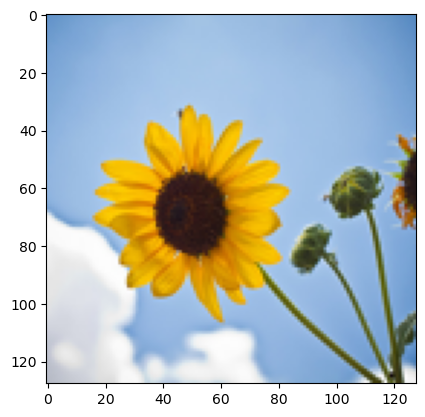

In [ ]:
test_img = df.loc[np.random.randint(low=0, high=len(df)-1), "image"]
plt.imshow(test_img)

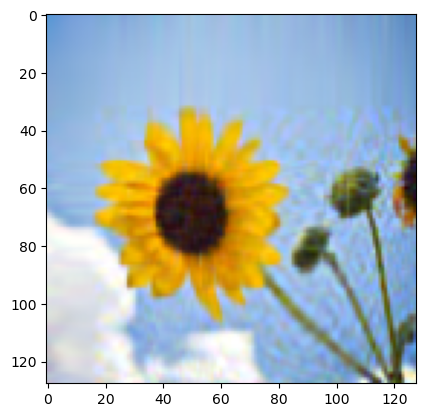

In [289]:
res, n_components = color_pca_compress(test_img)
plt.imshow(res)

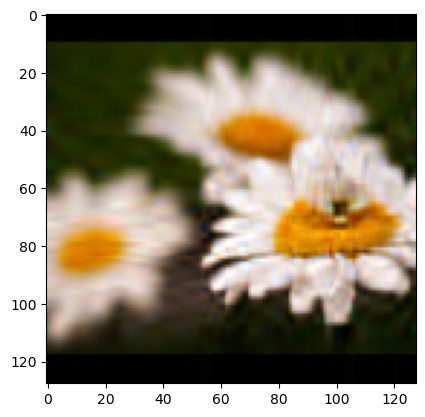

In [270]:
res, n_components = color_pca_compress(test_img, explained_variance = 0.99)
plt.imshow(res)

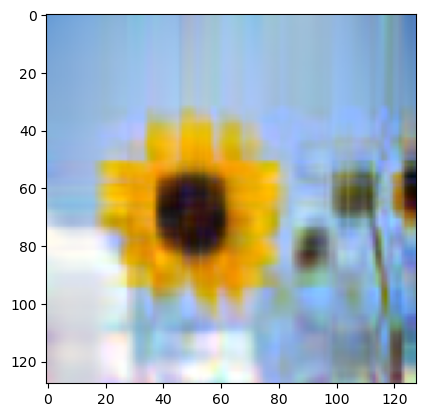

In [295]:
res, n_components = color_pca_compress(test_img, n_components = 5)
plt.imshow(res)

In [290]:
np.mean((test_img - res)**2)

np.float64(41.096333821614586)

In [291]:
from skimage.metrics import structural_similarity as ssim
score, diff = ssim(test_img, res, multichannel=True, channel_axis=-1, full=True)
score

np.float64(0.8057794604581877)

In [85]:
from io import BytesIO

def check_png_size(arr):
    file = BytesIO()
    img = Image.fromarray(arr)
    img.save(file, "png", quality="keep")
    return file.tell()

In [296]:
compression_ratio = check_png_size(test_img) / check_png_size(res)
compression_ratio

1.1270697674418604

In [128]:
df["compressed"], df["n_components"] = zip(*df["image"].apply(color_pca_compress))

In [129]:
df["raw_size"] = df["image"].apply(check_png_size)
df[".95_size"] = df["compressed"].apply(check_png_size)

In [131]:
df_no_img = df.drop(["image", "compressed"], axis=1, inplace=False)

In [146]:
df_no_img["compression_ratio"] = df_no_img["raw_size"] / df_no_img[".95_size"]
df_no_img["n_R"] = df_no_img["n_components"].apply(lambda x: x[0])
df_no_img["n_G"] = df_no_img["n_components"].apply(lambda x: x[1])
df_no_img["n_B"] = df_no_img["n_components"].apply(lambda x: x[2])

In [200]:
df_no_img["label"] = df_no_img["name"].apply(lambda x: x.split(".")[0].strip("0123456789"))

In [201]:
df_no_img

,name,n_components,raw_size,.95_size,compression_ratio,n_R,n_G,n_B,label
0,daisy0.png,"(32, 32, 8)",29265,26706,1.095821,32,32,8,daisy
1,daisy1.png,"(25, 25, 10)",31235,28976,1.077961,25,25,10,daisy
2,daisy10.png,"(16, 15, 14)",29950,29914,1.001203,16,15,14,daisy
3,daisy100.png,"(11, 11, 14)",30090,29456,1.021524,11,11,14,daisy
4,daisy101.png,"(16, 16, 17)",29417,30743,0.956868,16,16,17,daisy
...,...,...,...,...,...,...,...,...,...
3665,tulips3665.png,"(18, 21, 25)",36203,34115,1.061205,18,21,25,tulips
3666,tulips3666.png,"(13, 11, 8)",25249,25077,1.006859,13,11,8,tulips
3667,tulips3667.png,"(38, 40, 41)",39535,37906,1.042975,38,40,41,tulips
3668,tulips3668.png,"(41, 45, 43)",42826,41589,1.029743,41,45,43,tulips


In [148]:
import seaborn as sns

Text(0.5, 0, 'Compression ratio')

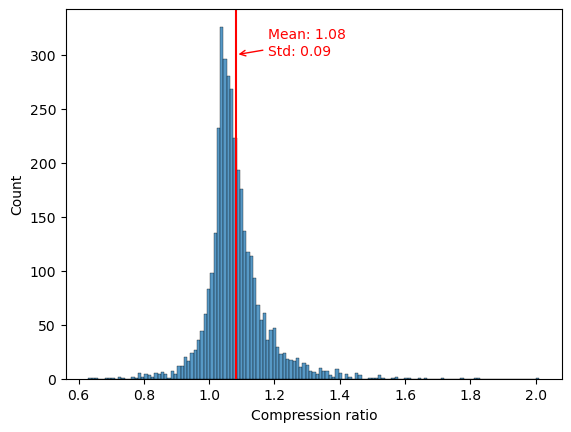

In [259]:
sns.histplot(data = df_no_img, x="compression_ratio")
mean = df_no_img["compression_ratio"].mean()
plt.axvline(mean, c="red")
plt.annotate(f"Mean: {mean:.2f}\nStd: {df_no_img["compression_ratio"].std():.2f}",
                xy=(mean, 300),
                xytext=(mean+0.1, 300),
                arrowprops={"color": "red", "arrowstyle": '->'},
                c="red")
plt.xlabel("Compression ratio")

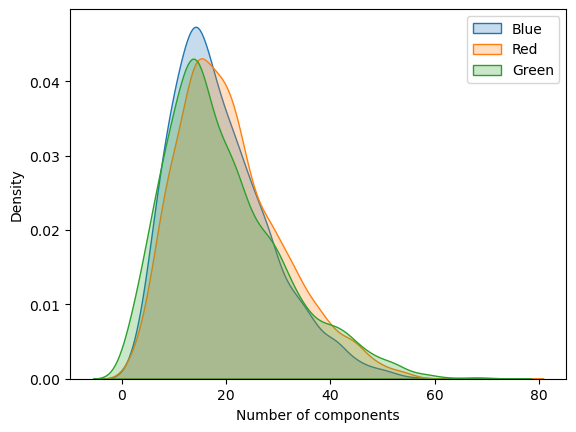

In [260]:
sns.kdeplot(data = df_no_img, x="n_R", fill=True, cmap="Reds")
sns.kdeplot(data = df_no_img, x="n_G", fill=True, cmap="Greens")
sns.kdeplot(data = df_no_img, x="n_B", fill=True, cmap="Blues")

plt.xlabel("Number of components")
plt.legend(labels=['Blue', 'Red', 'Green'])

<Axes: xlabel='n_R', ylabel='n_G'>

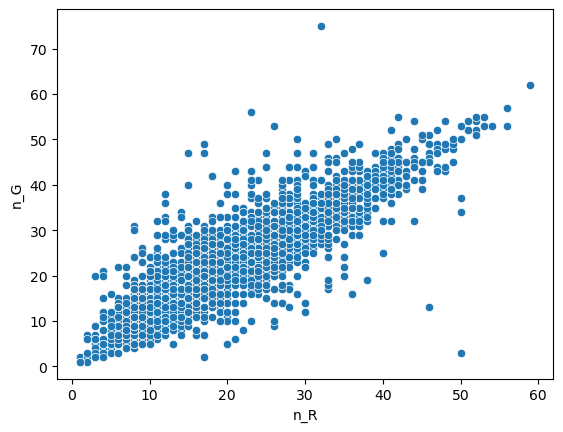

In [273]:
sns.scatterplot(data = df_no_img, x="n_R", y="n_G")


In [272]:
df.to_pickle("pca_dataframe.pkl")